# Hands-On Pertemuan 9: Spark SQL

## Tujuan:
- Mengasah keterampilan analisis data menggunakan Spark SQL.
- Melakukan lebih banyak latihan SQL yang mengarah ke skenario dunia nyata.
- Mempersiapkan mahasiswa untuk menggunakan Spark SQL dalam proyek besar.


### 1. Refresher: Basic SQL Operations in Spark SQL
- **Tugas 1**: Ulangi pemahaman Anda tentang SQL dasar dengan menjalankan queries sederhana pada dataset di Spark SQL.


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Pertemuan9").getOrCreate()
data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')
print("1. Pemahaman dasar: ")
spark.sql('SELECT * FROM employees').show()
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
spark.sql('SELECT AVG(Salary) FROM employees').show()


1. Pemahaman dasar: 
+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+



### 2. Advanced Queries for Data Analysis
Gunakan queries lebih kompleks, melibatkan grouping, filtering, dan subqueries.
- **Tugas 2**: Buat SQL query yang menghitung total gaji berdasarkan jenis kelamin dan usia.


In [3]:
from pyspark.sql import SparkSession
spark.sql('''
SELECT Gender, Age, SUM(Salary) as TotalSalary
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()


+------+---+-----------+
|Gender|Age|TotalSalary|
+------+---+-----------+
|     M| 23|       2700|
|     F| 28|       4100|
|     M| 34|       3000|
+------+---+-----------+



- **Tugas Tambahan 2**:
1. Cari rata-rata gaji per departemen.
2. Temukan karyawan yang memiliki gaji di atas rata-rata untuk gender masing-masing.
3. Buat ranking karyawan berdasarkan gaji dalam departemen mereka.


In [4]:
from pyspark.sql import SparkSession
AVGSalary_Dept = spark.sql("""
SELECT DeptID, AVG(Salary) AS AVGSalary
    FROM employees
    GROUP BY DeptID
""")


AVGSalary_Gender = spark.sql("""
SELECT Gender, AVG(Salary) AS AVGSalary
    FROM employees
    GROUP BY Gender
""")
AVGSalary_Gender.createOrReplaceTempView('avg_gender')

AboveAVGSalary_Gender = spark.sql("""
SELECT e.Name, e.Gender, e.Salary, a.AVGSalary
    FROM employees e
    JOIN avg_gender a
    ON e.Gender = a.Gender
    WHERE e.Salary > a.AVGSalary
    ORDER BY e.Gender
""")

#Ranking Karyawan berdasarkan gaji dalam departemen
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc

windowDept = Window.partitionBy('DeptID').orderBy(desc('Salary'))
rankeddf = df.withColumn('Rank',row_number().over(windowDept))


print("1.) Rata-rata gaji per Departemen: ")
AVGSalary_Dept.show()
print("2.) Karyawan dengan gaji diatas rata-rata untuk setiap gender: ")
AboveAVGSalary_Gender.show()
print("3.) Ranking karyawan berdasarkan gaji dalam departemen: ")
rankeddf.show()

1.) Rata-rata gaji per Departemen: 
+------+---------+
|DeptID|AVGSalary|
+------+---------+
|     1|   2850.0|
|     2|   4100.0|
+------+---------+

2.) Karyawan dengan gaji diatas rata-rata untuk setiap gender: 
+-----+------+------+---------+
| Name|Gender|Salary|AVGSalary|
+-----+------+------+---------+
|James|     M|  3000|   2850.0|
+-----+------+------+---------+

3.) Ranking karyawan berdasarkan gaji dalam departemen: 
+-----+---+------+------+------+----+
| Name|Age|Gender|Salary|DeptId|Rank|
+-----+---+------+------+------+----+
|James| 34|     M|  3000|     1|   1|
|  Lee| 23|     M|  2700|     1|   2|
| Anna| 28|     F|  4100|     2|   1|
+-----+---+------+------+------+----+



### 3. Penggunaan Window Functions dan Subqueries
Latihan penggunaan window functions untuk menemukan karyawan dengan gaji tertinggi dan urutannya berdasarkan kelompok usia.
- **Tugas 3**: Terapkan window functions untuk menemukan top 3 karyawan dalam kelompok usia tertentu.


In [5]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc
print("3. Top 3 karyawan kelompok usia tertentu: ")
spark.sql('''
SELECT Name, Age, Salary, ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) as rank
FROM employees
''').show()


3. Top 3 karyawan kelompok usia tertentu: 
+-----+---+------+----+
| Name|Age|Salary|rank|
+-----+---+------+----+
|  Lee| 23|  2700|   1|
| Anna| 28|  4100|   1|
|James| 34|  3000|   1|
+-----+---+------+----+



### 4. Advanced Spark SQL Queries
Menjelajahi queries yang lebih kompleks yang melibatkan multiple joins, subqueries, dan window functions.
- **Tugas 4**: Demonstrasi penggunaan multi-level joins dan subqueries untuk analisis data yang mendalam.


In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Pertemuan9').getOrCreate()

# Data setup for complex SQL queries
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Complex SQL query involving multiple joins and subqueries
print("4. Tugas 4: ")

#Query untuk filtering data
spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''').show()


4. Tugas 4: 
+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+



Latihan mandiri untuk memperkuat pemahaman tentang Spark SQL dalam analisis data terdistribusi.
- **Tugas 5**: Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
- **Tugas 6**: Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.


In [7]:
from pyspark.sql import SparkSession
#Tugas 5
spark.sql('''
SELECT AVG(e.Salary) as AverageSalary, d.DeptId FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptId
''').show()
spark.sql('''
SELECT e.Name, e.Age, e.Salary, d.DeptId, ROW_NUMBER() OVER (PARTITION BY d.DeptName ORDER BY e.Salary DESC) as rank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
''').show()

#Tugas 6
spark.sql('''
SELECT e.Age, d.DeptId, AVG(e.Salary) AS AverageSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY e.Age, d.DeptId
ORDER BY d.DeptId, e.Age
''').show()

+-------------+------+
|AverageSalary|DeptId|
+-------------+------+
|       2850.0|     1|
|       4100.0|     2|
+-------------+------+

+-----+---+------+------+----+
| Name|Age|Salary|DeptId|rank|
+-----+---+------+------+----+
|James| 34|  3000|     1|   1|
|  Lee| 23|  2700|     1|   2|
| Anna| 28|  4100|     2|   1|
+-----+---+------+------+----+

+---+------+-------------+
|Age|DeptId|AverageSalary|
+---+------+-------------+
| 23|     1|       2700.0|
| 34|     1|       3000.0|
| 28|     2|       4100.0|
+---+------+-------------+



### 5. Advanced Data Analysis and Visualization
Penerapan teknik analisis data yang lebih canggih dan visualisasi menggunakan PySpark dan matplotlib.
- **Tugas 7**: Lakukan analisis tren gaji menggunakan Spark SQL dan visualisasikan hasilnya.


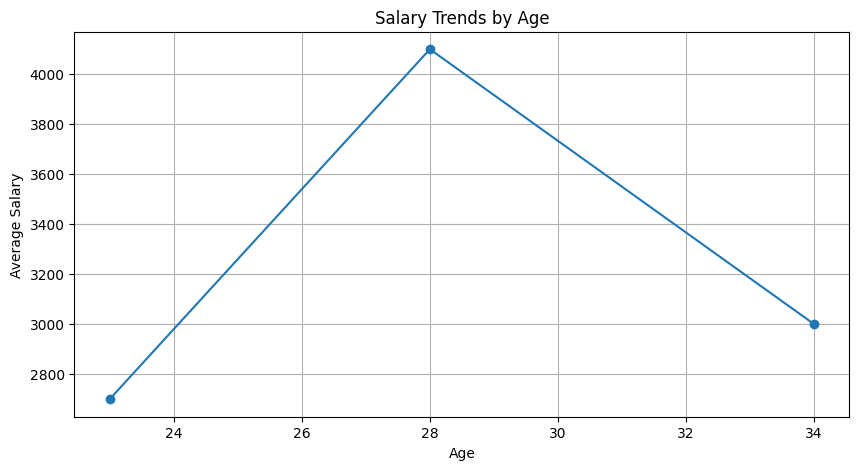

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Advanced data analysis with visualization
salary_trends = spark.sql('''
SELECT Age, AVG(Salary) AS AverageSalary
FROM employees
GROUP BY Age
ORDER BY Age
''').toPandas()

# visualiasasi data
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()


### 6. Homework
- **Tugas 1**: Gunakan Spark SQL untuk mencari total gaji dan jumlah karyawan per departemen. Buat visualisasi perbandingan antar departemen.
- **Tugas 2**: Temukan karyawan dengan gaji di atas rata-rata dalam setiap kelompok usia dan visualisasikan data ini dalam bentuk grafik batang atau pie chart.
- **Tugas 3**: Buat dataset yang lebih besar (misalnya, 100+ baris) dan lakukan analisis mendalam menggunakan SQL functions seperti `SUM()`, `AVG()`, `COUNT()`, serta `JOIN` antar tabel serta buat visualisasi yang menarik.


##### Tugas 1

1. Total gaji per departemen: 
+------+-----------+
|DeptID|TotalSalary|
+------+-----------+
|     1|       5700|
|     2|       4100|
+------+-----------+



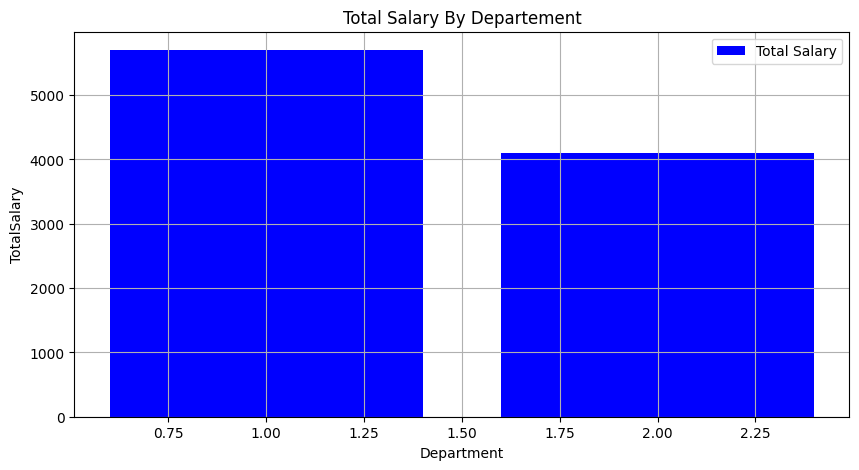

In [9]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

TtlSalary_Dept=spark.sql('''
SELECT DeptID, SUM(Salary) AS TotalSalary

FROM employees
GROUP BY DeptID
ORDER BY DeptID
''')
print("1. Total gaji per departemen: ")
TtlSalary_Dept.show()

#Visualisasi data
Visual=TtlSalary_Dept.toPandas()
plt.figure(figsize=(10, 5))
plt.bar(Visual['DeptID'], Visual['TotalSalary'], color='blue', label='Total Salary')
plt.xlabel('Department')
plt.ylabel('TotalSalary')
plt.title('Total Salary By Departement')
plt.legend()
plt.grid(True)
plt.show()

#####Tugas 2

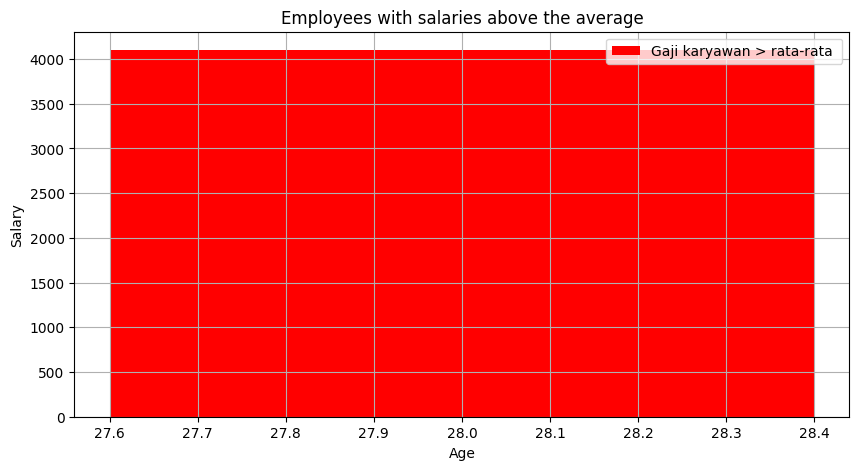

In [12]:
AvgAge = spark.sql ('''
SELECT Name, Age, Salary
FROM employees
WHERE Salary > (SELECT AVG(Salary) FROM employees)
''').toPandas()

plt.figure(figsize=(10, 5))
plt.bar(AvgAge['Age'], AvgAge['Salary'], color='Red', label='Gaji karyawan > rata-rata ')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.title('Employees with salaries above the average')
plt.legend()
plt.grid(True)
plt.show()

#####Tugas 3

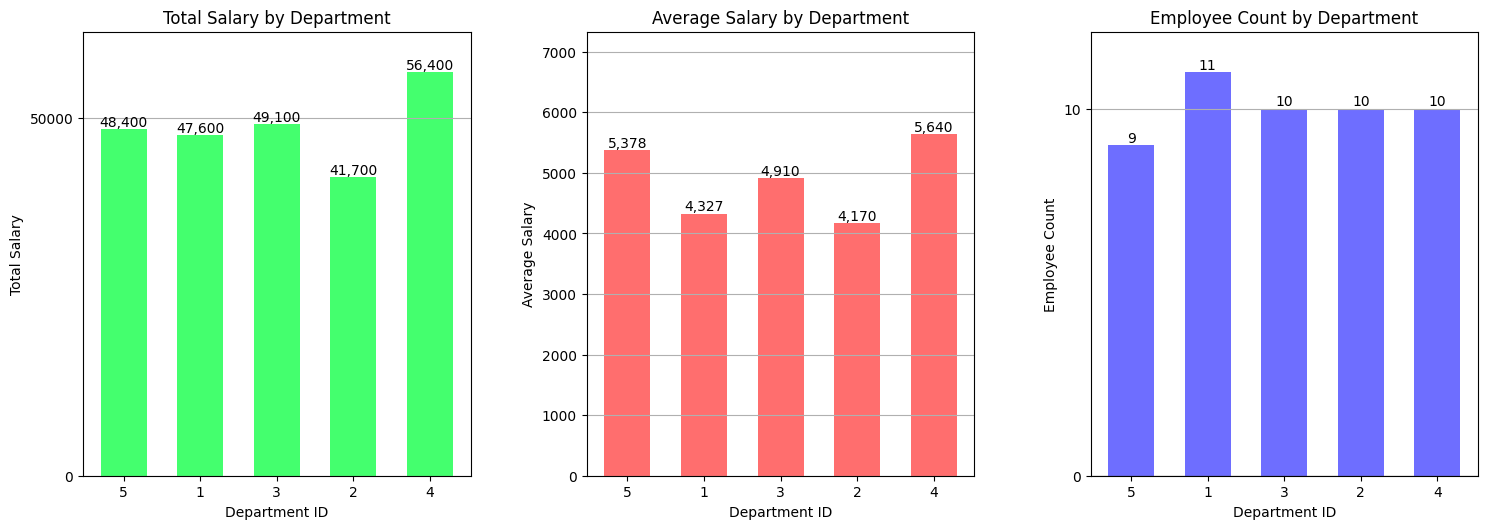

In [36]:
employees = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1),
    ('John', 45, 'M', 5400, 3),
    ('Emma', 32, 'F', 4800, 2),
    ('Michael', 29, 'M', 3100, 1),
    ('Sophia', 25, 'F', 3600, 3),
    ('Liam', 40, 'M', 6200, 4),
    ('Olivia', 35, 'F', 5900, 4),
    ('Noah', 42, 'M', 7000, 5),
    ('Ava', 30, 'F', 4000, 2),
    ('William', 33, 'M', 5200, 3),
    ('Mia', 26, 'F', 3300, 1),
    ('Jameson', 27, 'M', 4500, 2),
    ('Ethan', 31, 'M', 4700, 4),
    ('Amelia', 29, 'F', 4200, 5),
    ('Alexander', 36, 'M', 6800, 4),
    ('Isabella', 34, 'F', 5500, 5),
    ('Lucas', 28, 'M', 4400, 3),
    ('Charlotte', 38, 'F', 6100, 1),
    ('Daniel', 24, 'M', 3200, 2),
    ('Harper', 37, 'F', 5800, 3),
    ('Henry', 41, 'M', 7400, 4),
    ('Evelyn', 39, 'F', 6300, 5),
    ('Sebastian', 26, 'M', 3500, 1),
    ('Abigail', 25, 'F', 3400, 2),
    ('Matthew', 35, 'M', 5100, 3),
    ('Ella', 30, 'F', 4100, 4),
    ('Joseph', 43, 'M', 7500, 5),
    ('Scarlett', 29, 'F', 4600, 1),
    ('David', 33, 'M', 5300, 2),
    ('Victoria', 27, 'F', 3600, 3),
    ('Wyatt', 32, 'M', 4800, 4),
    ('Grace', 24, 'F', 3000, 5),
    ('Gabriel', 37, 'M', 5700, 1),
    ('Zoe', 31, 'F', 4300, 2),
    ('Logan', 28, 'M', 4400, 3),
    ('Lily', 36, 'F', 6000, 4),
    ('Jackson', 40, 'M', 6500, 5),
    ('Hannah', 34, 'F', 5500, 1),
    ('Elijah', 26, 'M', 3600, 2),
    ('Nora', 38, 'F', 6200, 3),
    ('Aiden', 31, 'M', 4700, 4),
    ('Luna', 27, 'F', 3800, 5),
    ('Samuel', 35, 'M', 5100, 1),
    ('Aria', 29, 'F', 4500, 2),
    ('Benjamin', 33, 'M', 5400, 3),
    ('Ella', 37, 'F', 5800, 4),
    ('Isaac', 29, 'M', 4600, 5),
    ('Mila', 32, 'F', 5000, 1)
]

columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
large_df = spark.createDataFrame(employees, schema=columns)
large_df.createOrReplaceTempView('employees')

salary_analysis = spark.sql('''
SELECT DeptId, SUM(Salary) AS TotalSalary, AVG(Salary) AS AverageSalary, COUNT(Name) AS EmployeeCount
FROM employees
GROUP BY DeptId
''').toPandas()

import numpy as np
x = np.arange(len(salary_analysis['DeptId']))
bar_width = 0.6

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.bar(x, salary_analysis['TotalSalary'], width=bar_width, color='#44ff6e')
ax1.set_xlabel('Department ID')
ax1.set_ylabel('Total Salary')
ax1.set_title('Total Salary by Department')
ax1.set_xticks(x)
ax1.set_xticklabels(salary_analysis['DeptId'])

ax1.set_ylim(0, salary_analysis['TotalSalary'].max() * 1.1)
ax1.set_yticks(np.arange(0, salary_analysis['TotalSalary'].max() * 1.1, 50000))
ax1.grid(axis='y')

for i in range(len(salary_analysis)):
    ax1.text(i, salary_analysis['TotalSalary'][i],
             f"{salary_analysis['TotalSalary'][i]:,.0f}",
             ha='center', va='bottom', color='black')

ax2.bar(x, salary_analysis['AverageSalary'], width=bar_width, color='#ff6e6e')
ax2.set_xlabel('Department ID')
ax2.set_ylabel('Average Salary')
ax2.set_title('Average Salary by Department')
ax2.set_xticks(x)
ax2.set_xticklabels(salary_analysis['DeptId'])

ax2.set_ylim(0, salary_analysis['AverageSalary'].max() * 1.3)
ax2.set_yticks(np.arange(0, salary_analysis['AverageSalary'].max() * 1.3, 1000))
ax2.grid(axis='y')

for i in range(len(salary_analysis)):
    ax2.text(i, salary_analysis['AverageSalary'][i],
             f"{salary_analysis['AverageSalary'][i]:,.0f}",
             ha='center', va='bottom', color='black')

ax3.bar(x, salary_analysis['EmployeeCount'], width=bar_width, color='#6e6eff')
ax3.set_xlabel('Department ID')
ax3.set_ylabel('Employee Count')
ax3.set_title('Employee Count by Department')
ax3.set_xticks(x)
ax3.set_xticklabels(salary_analysis['DeptId'])

ax3.set_ylim(0, salary_analysis['EmployeeCount'].max() * 1.1)
ax3.set_yticks(np.arange(0, salary_analysis['EmployeeCount'].max() * 1.1, 10))
ax3.grid(axis='y')

for i in range(len(salary_analysis)):
    ax3.text(i, salary_analysis['EmployeeCount'][i],
             f"{salary_analysis['EmployeeCount'][i]:,.0f}",
             ha='center', va='bottom', color='black')

plt.subplots_adjust(wspace=0.3, top=0.85)
plt.axhline(0, color='black', linewidth=0.8)
plt.show()